In [1]:
import mujoco_py
import numpy as np
import matplotlib.pyplot as plt
from mujoco_parser import MuJoCoParserClass, set_env_joint_configuration, get_env_joint_names, print_env_joint_infos
from util import rpy2r,pr2t,t2pr
from util_fk import *
import cv2

np.set_printoptions(precision=2)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("Ready.")

Done.
Ready.


### Parsing `UR5e`

In [2]:
# env = MuJoCoParserClass(name='UR5e',xml_path='../asset/ur5e/test_calibration.xml')

env = MuJoCoParserClass(name='UR5e',xml_path='../asset/ur5e/UR5_rg2_gripper.xml')
print ("[%s] parsed."%(env.name))

[UR5e] parsed.


### Get camera informations

In [3]:
cam_infos = env.set_cam_infos(cam_distance  = 0.0,
                    cam_azimuth   = 0.0,
                    cam_elevation = -90.0,
                    cam_lookat    = [1.4,0.0,2.0])
cam_infos

{'cam_distance': 0.0,
 'cam_azimuth': 0.0,
 'cam_elevation': -90.0,
 'cam_lookat': array([1.4, 0. , 2. ])}

### Render a scene

[0/6] joint_name:[ur_shoulder_pan_joint]
[0/6] joint_configurations:[-1.571]
[1/6] joint_name:[ur_shoulder_lift_joint]
[1/6] joint_configurations:[-2.356]
[2/6] joint_name:[ur_elbow_joint]
[2/6] joint_configurations:[2.356]
[3/6] joint_name:[ur_wrist_1_joint]
[3/6] joint_configurations:[1.571]
[4/6] joint_name:[ur_wrist_2_joint]
[4/6] joint_configurations:[0.785]
[5/6] joint_name:[ur_wrist_3_joint]
[5/6] joint_configurations:[-1.571]


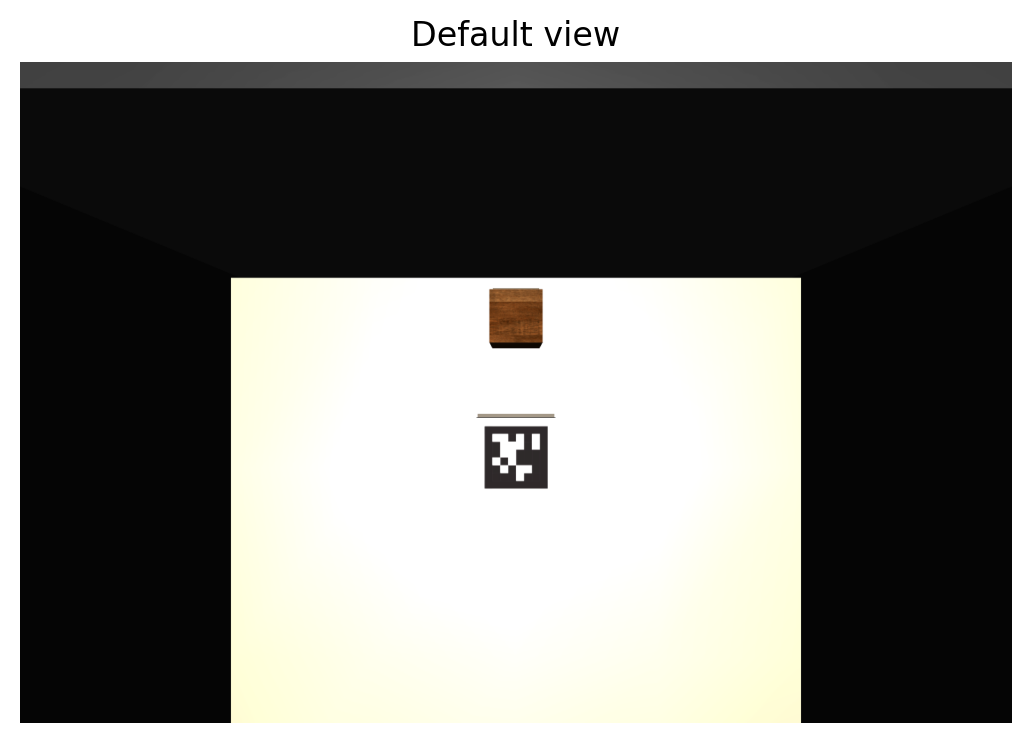

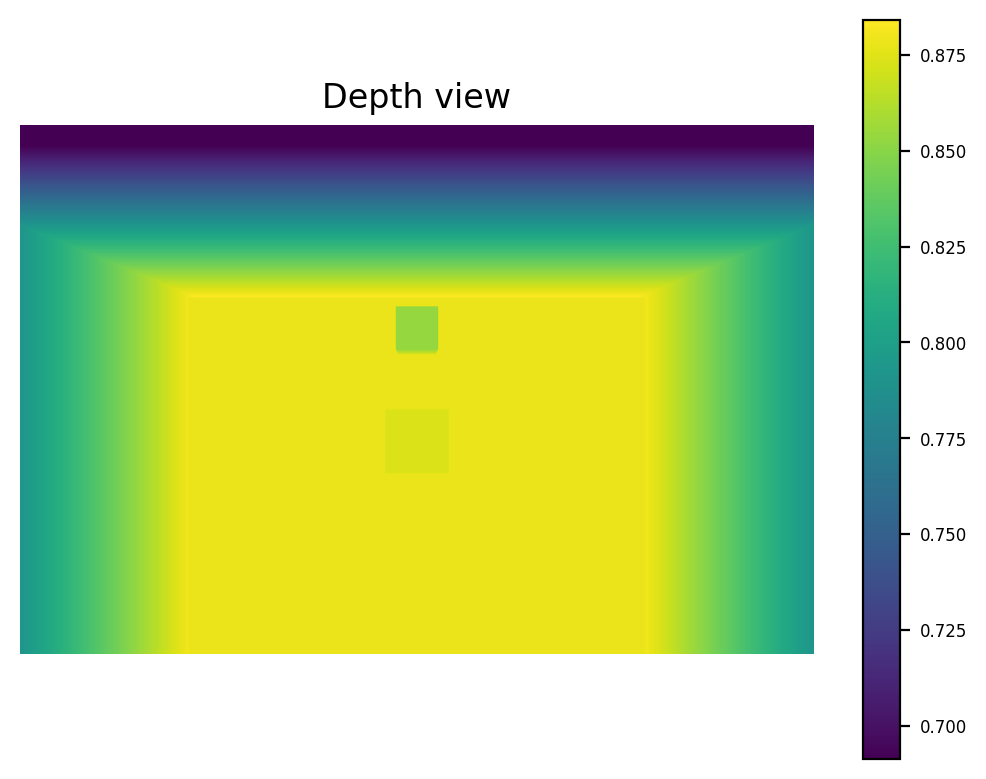

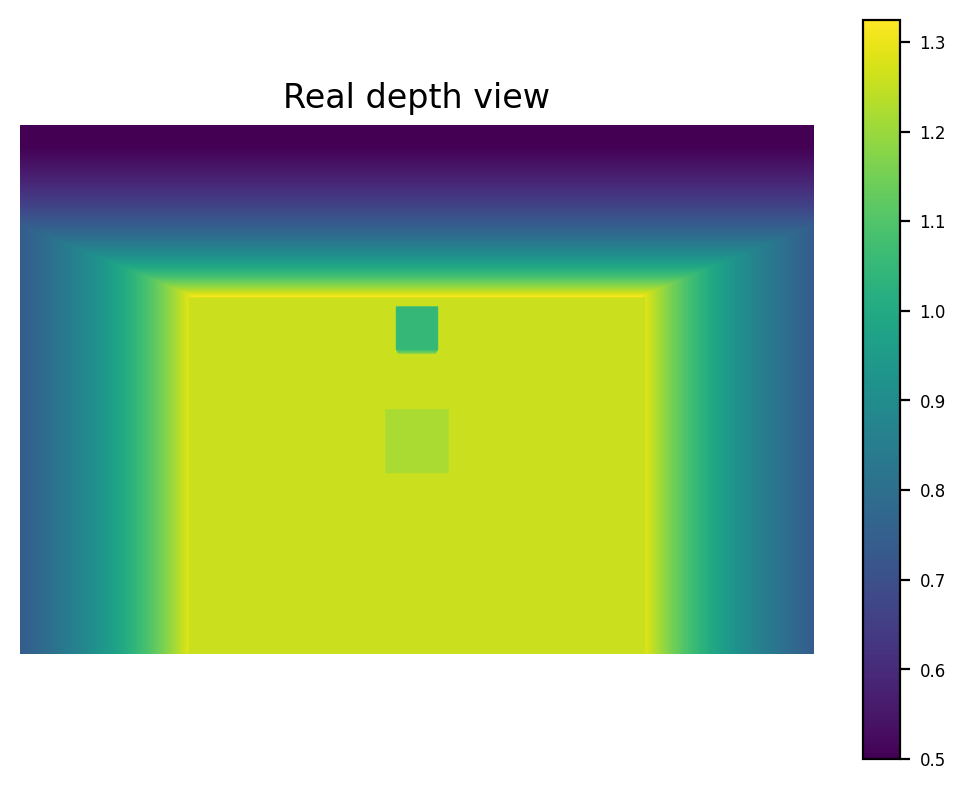

In [4]:
import math

width = 1500
height = 1000
ur_joint_idx = np.array([0, 1, 2, 3, 4, 5, 6], dtype=np.int32)

# Set AprilTag configurations
april_addr_z = env.sim.model.get_joint_qpos_addr('box_checker_z')
env.sim.data.qpos[april_addr_z] = -math.pi/2

# Set Joint Configurations
init_configurations = [-math.pi/2, -3*math.pi/4, 3*math.pi/4, math.pi/2, math.pi/4, -math.pi/2 ]
set_env_joint_configuration(env, init_configurations, prefix='ur_')
print_env_joint_infos(env, prefix='ur_')

for _ in range(2):
    img = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=width, height=height, depth_toggle=False, camera_name="track")
    img_depth = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=width, height=height, depth_toggle=True, camera_name="track")
    img_real = env.depth_2_meters(img_depth)

plt.imshow(img); plt.axis('off')
plt.title("Default view")
plt.show()

plt.imshow(img_depth); plt.axis('off')
plt.title("Depth view")
plt.colorbar()
plt.show()

plt.imshow(img_real); plt.axis('off')
plt.title("Real depth view")
plt.colorbar()
plt.show()

### Get center_point and pose using `AprilTag`

In [5]:
import apriltag

detector = apriltag.Detector()
img_BGR = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
img_Gray = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2GRAY)

# detections, dimg = detector.detect(fram_gray, return_image=True)
results = detector.detect(img_Gray)

cam_matrix, _, _ = env.camera_matrix_and_pose(width=width, height=height, camera_name="main1")
fx = cam_matrix[0][0]
cx = cam_matrix[0][2]
fy = cam_matrix[1][1]
cy = cam_matrix[1][2]

cam_params = [fx, fy, cx, cy]

# Render the detections on the image
if len(results) > 0:
    for r in results:
        pose, e0, e1 = detector.detection_pose(detection=r, camera_params=cam_params, tag_size=0.12)
        
        poseRotation = pose[:3, :3]
        poseTranslation = pose[:3, 3]


In [6]:
center_x = int(results[0].center.ravel()[0])
center_y = int(results[0].center.ravel()[1])
center_int = np.array((center_x, center_y))
center_int

array([750, 598])

In [7]:
img_depth[center_int[0], center_int[1]]

0.87813205

In [8]:
img_real[center_int[0]][center_int[1]]

1.2600008

### Compute depth imgage(depth) to `3d point (x,y,z)`

In [30]:
def convert_from_uvd(u, v, d, cam_matrix):
    """
        pxToMetre: Constant, depth scale factor
        cx: Center x of Camera
        cy: Center y of Camera
        focalx: Focal length
        focaly: Focal length 
    """

    pxToMetre = 1

    focalx = cam_matrix[0][0]
    cx = cam_matrix[0][2]
    focaly = cam_matrix[1][1]
    cy = cam_matrix[1][2]

    d *= pxToMetre
    x_over_z = (cx - u) / focalx
    y_over_z = (cy - v) / focaly
    z = d / np.sqrt(1. + x_over_z**2 + y_over_z**2)
    x = x_over_z * z
    y = y_over_z * z

    return -y, x, z

def compute_xyz(depth_img, cam_matrix):

    # , fx, fy, px, py, height, width
    fx = cam_matrix[0][0]
    cx = cam_matrix[0][2]
    fy = cam_matrix[1][1]
    cy = cam_matrix[1][2]

    height = 1000
    width = 1500

    indices = np.indices((height, width), dtype=np.float32).transpose(1, 2, 0)
    
    z_e = depth_img
    x_e = (indices[..., 1] - cx) * z_e / fx
    y_e = (indices[..., 0] - cy) * z_e / fy
    
    # Order of y_ e is reversed !
    xyz_img = np.stack([-y_e, x_e, z_e], axis=-1) # Shape: [H x W x 3]
    return xyz_img

def convert_3d_position(img_real):
    """
        plot 2D images convert to 3D point map
    """
    total_point_real = []
    for i in range(img_real.shape[0]):
        for j in range(img_real.shape[1]): 
            x, y, z = convert_from_uvd(i, j, np.average(img_real[i][j])/(255), cam_matrix)
            total_point_real.append([x,y,z])
    return total_point_real

def plot_point3d(points, rotation_x, rotation_y, rotation_z):
    fig = plt.figure(figsize=(30,10))


    ax = fig.add_subplot(1, 3, 1, projection="3d")
    ax.scatter([point[0] for point in points], [point[1] for point in points], [-point[2] for point in points], s=0.05)
    ax.set_xlabel("X[m]", fontsize=16)
    ax.set_ylabel("Y[m]", fontsize=16)
    ax.set_zlabel("Z[m]", fontsize=16)
    ax.view_init(-10, 0)
    # ax.view_init(rotation_x, rotation_y, rotation_z)
    ax.set_zlim(0,1)

    # plt.title(f"{str(np_cloud)}")
    plt.title("3D Point Plot", fontsize=20)
    plt.show()

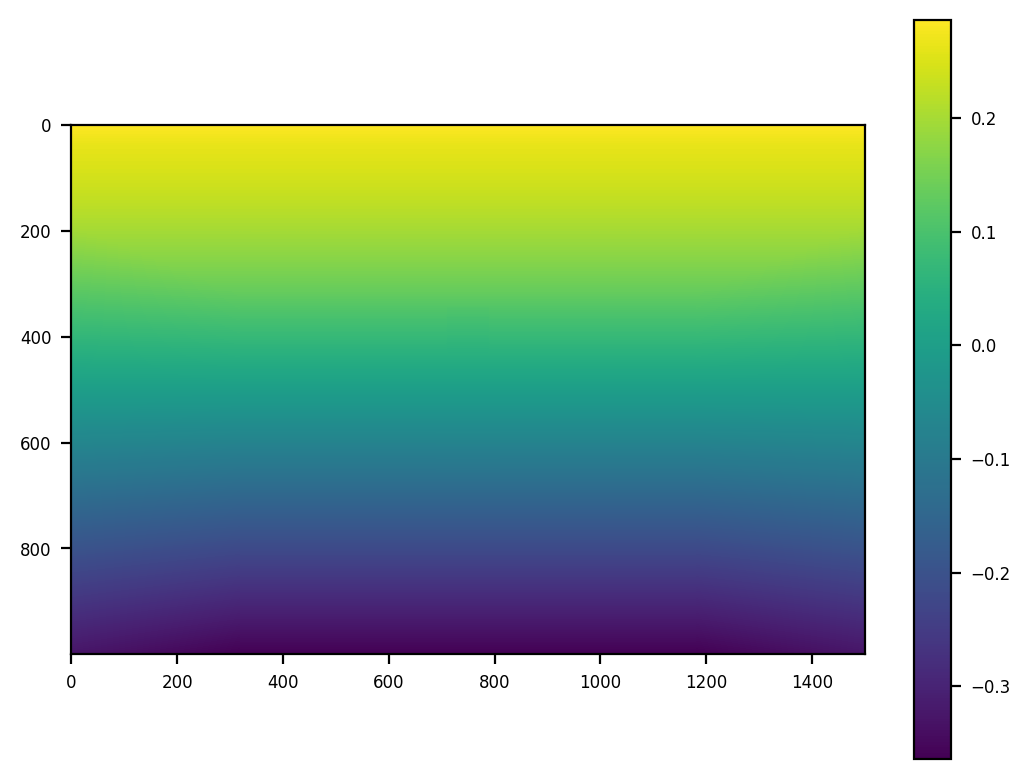

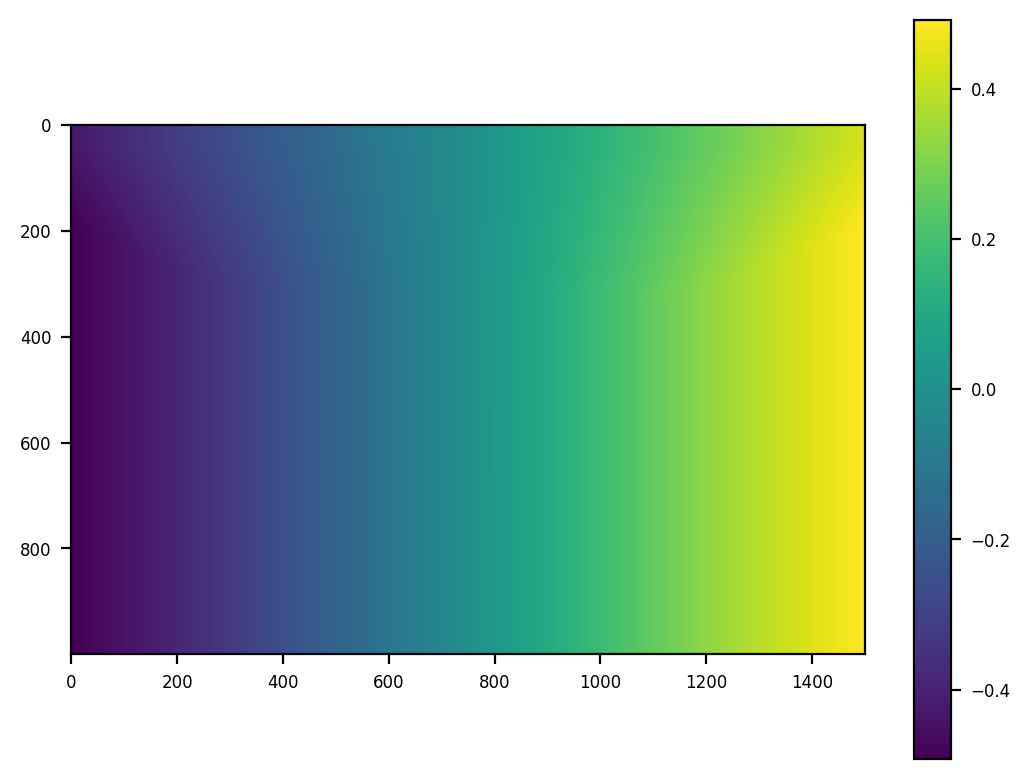

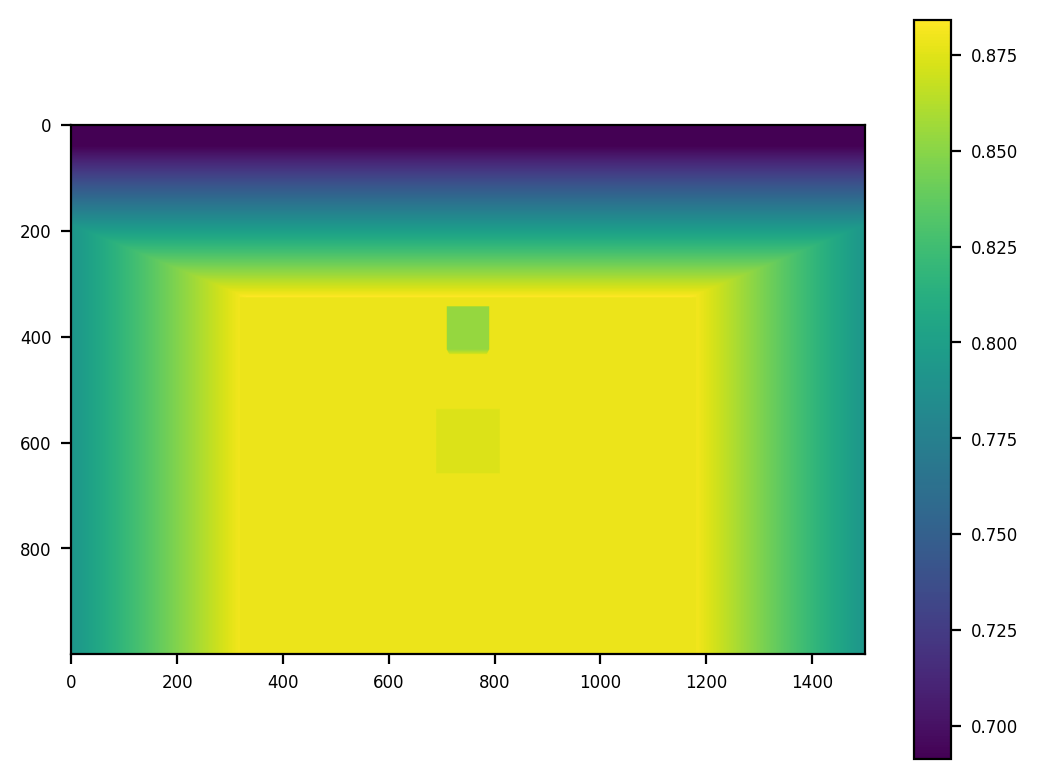

In [31]:
img_3d = compute_xyz(img_depth, cam_matrix)
for i in range(3):
    plt.imshow(img_3d[:,:,i])
    plt.colorbar()
    plt.show()

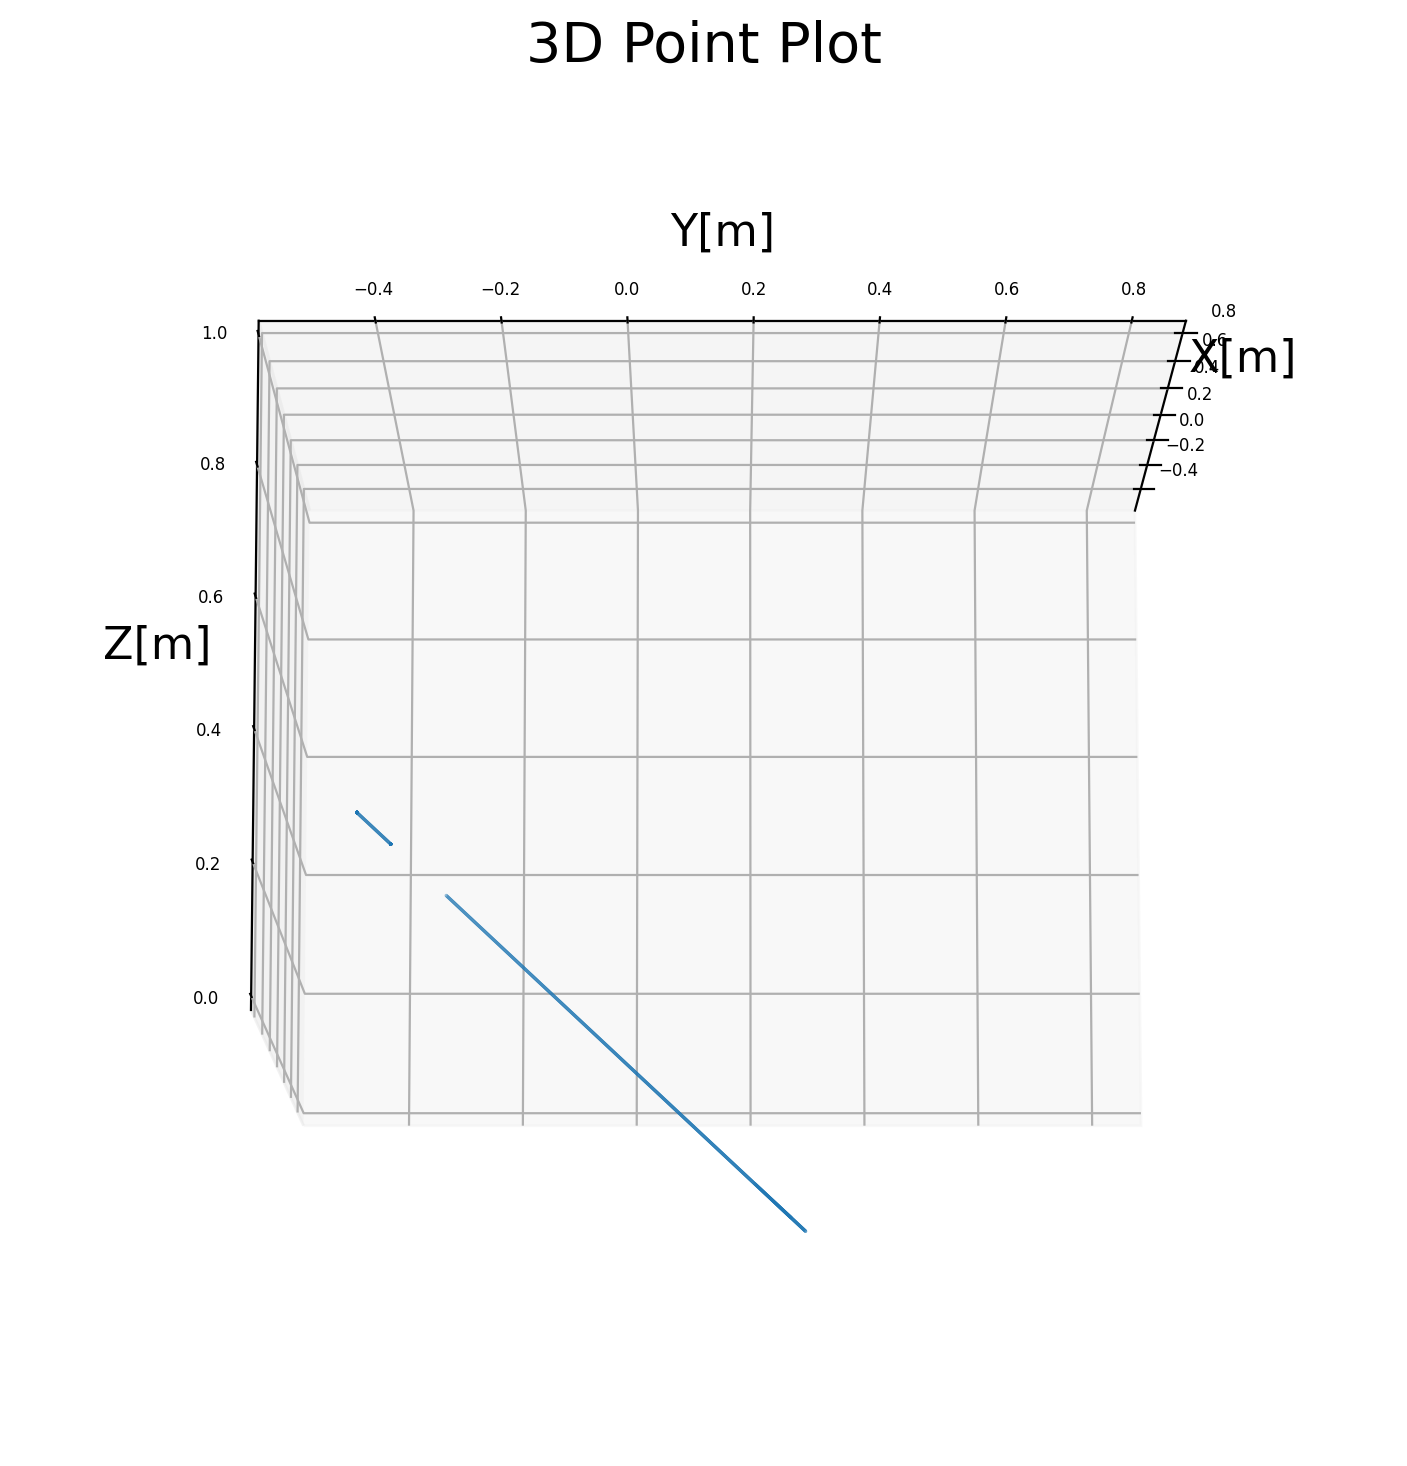

In [32]:
plot_point3d(img_3d, 90, 180, 0)

In [21]:
xyz = convert_from_uvd(center_int[0], center_int[1], img_real, cam_matrix)
xyz_d = convert_from_uvd(center_int[0], center_int[1], img_depth, cam_matrix)


In [34]:
img_real = np.array(img_real)
img_3d_points = convert_3d_position(img_real)

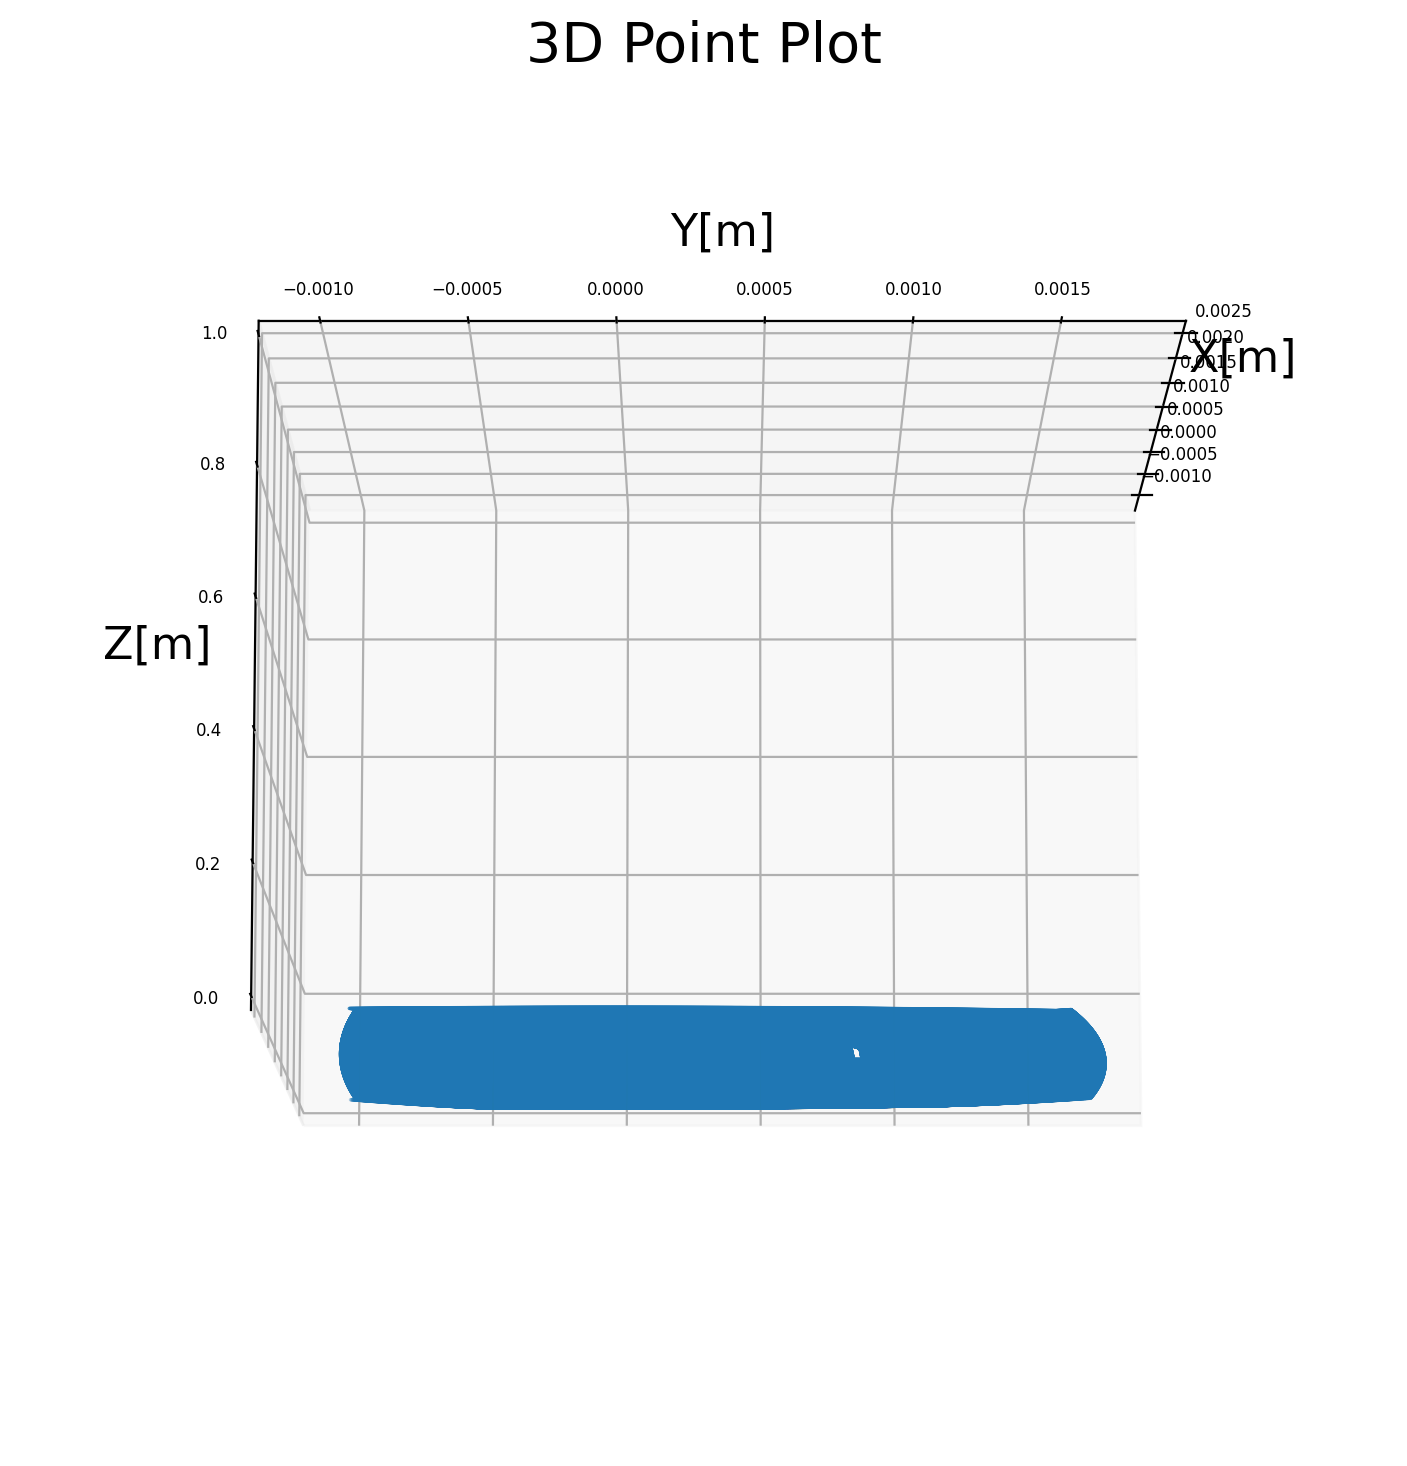

In [35]:
plot_point3d(img_3d_points, 90, 180, 0)

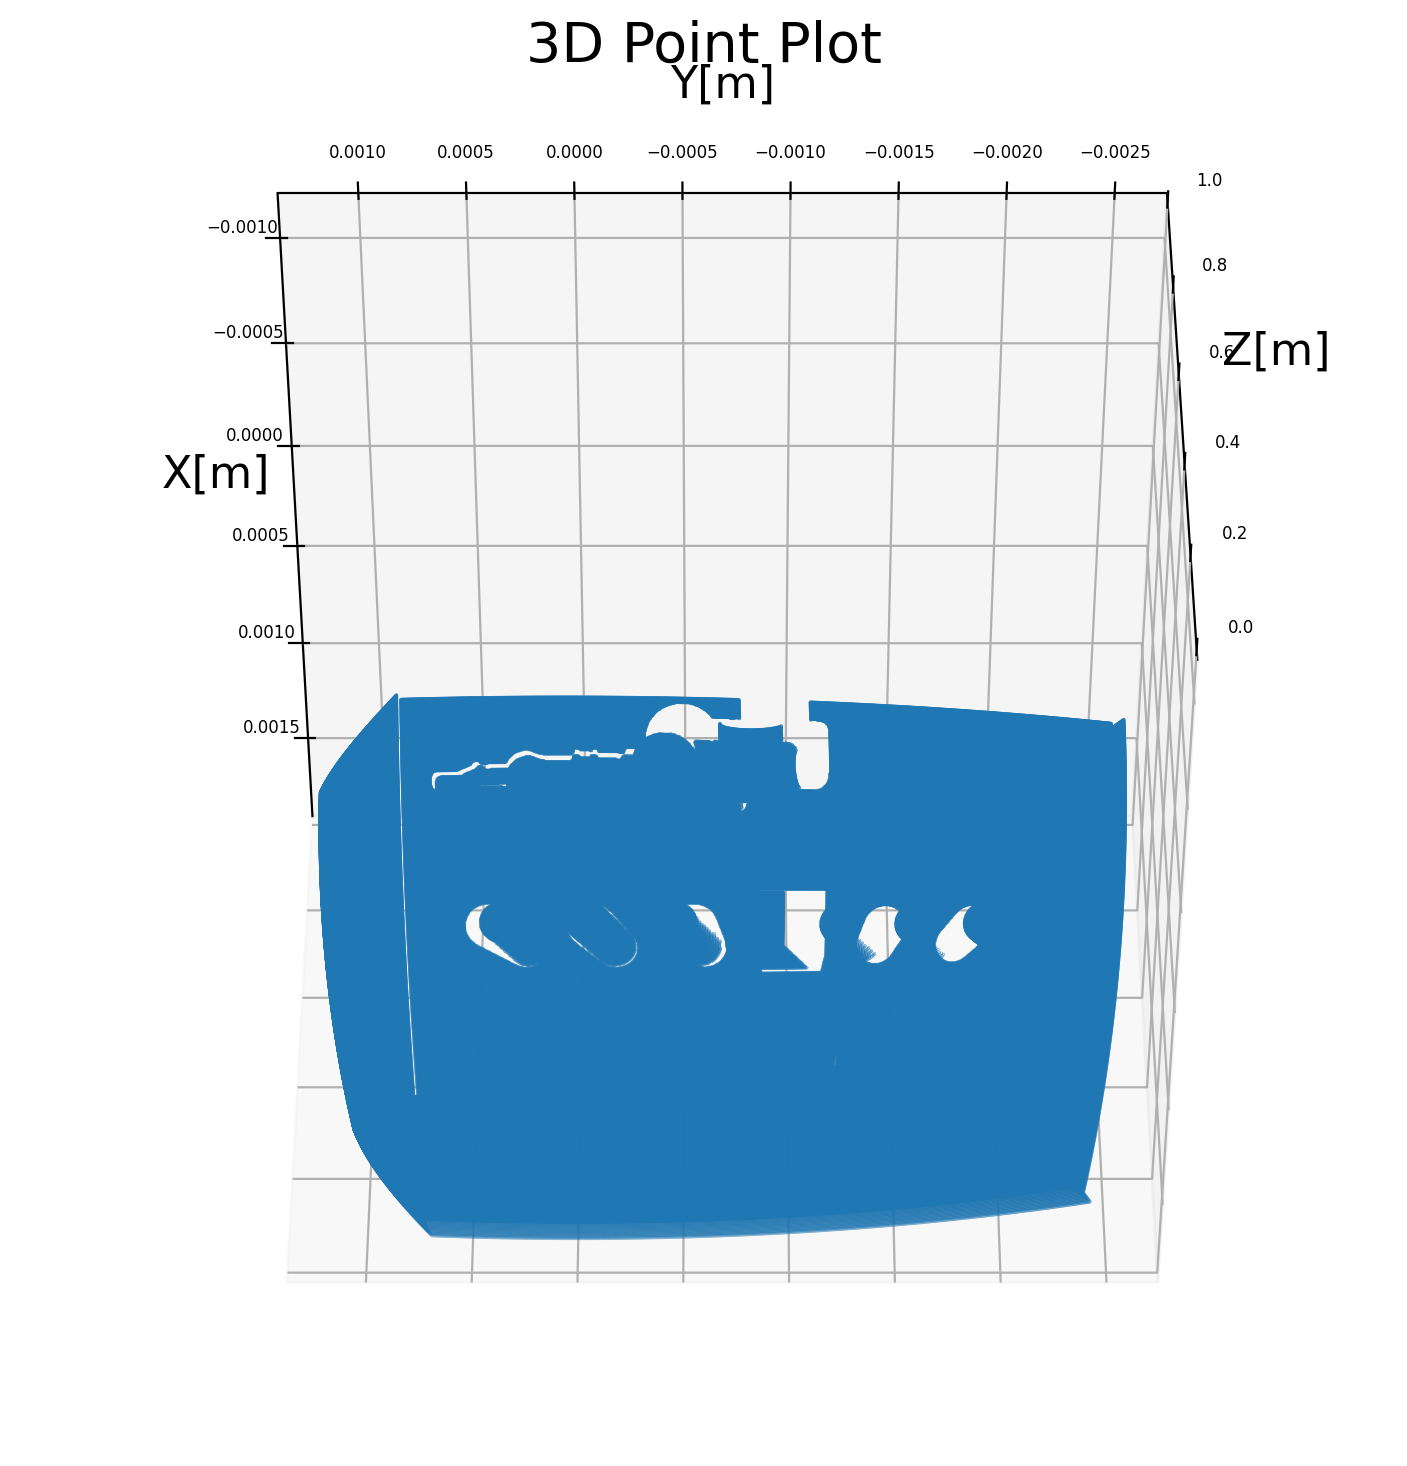

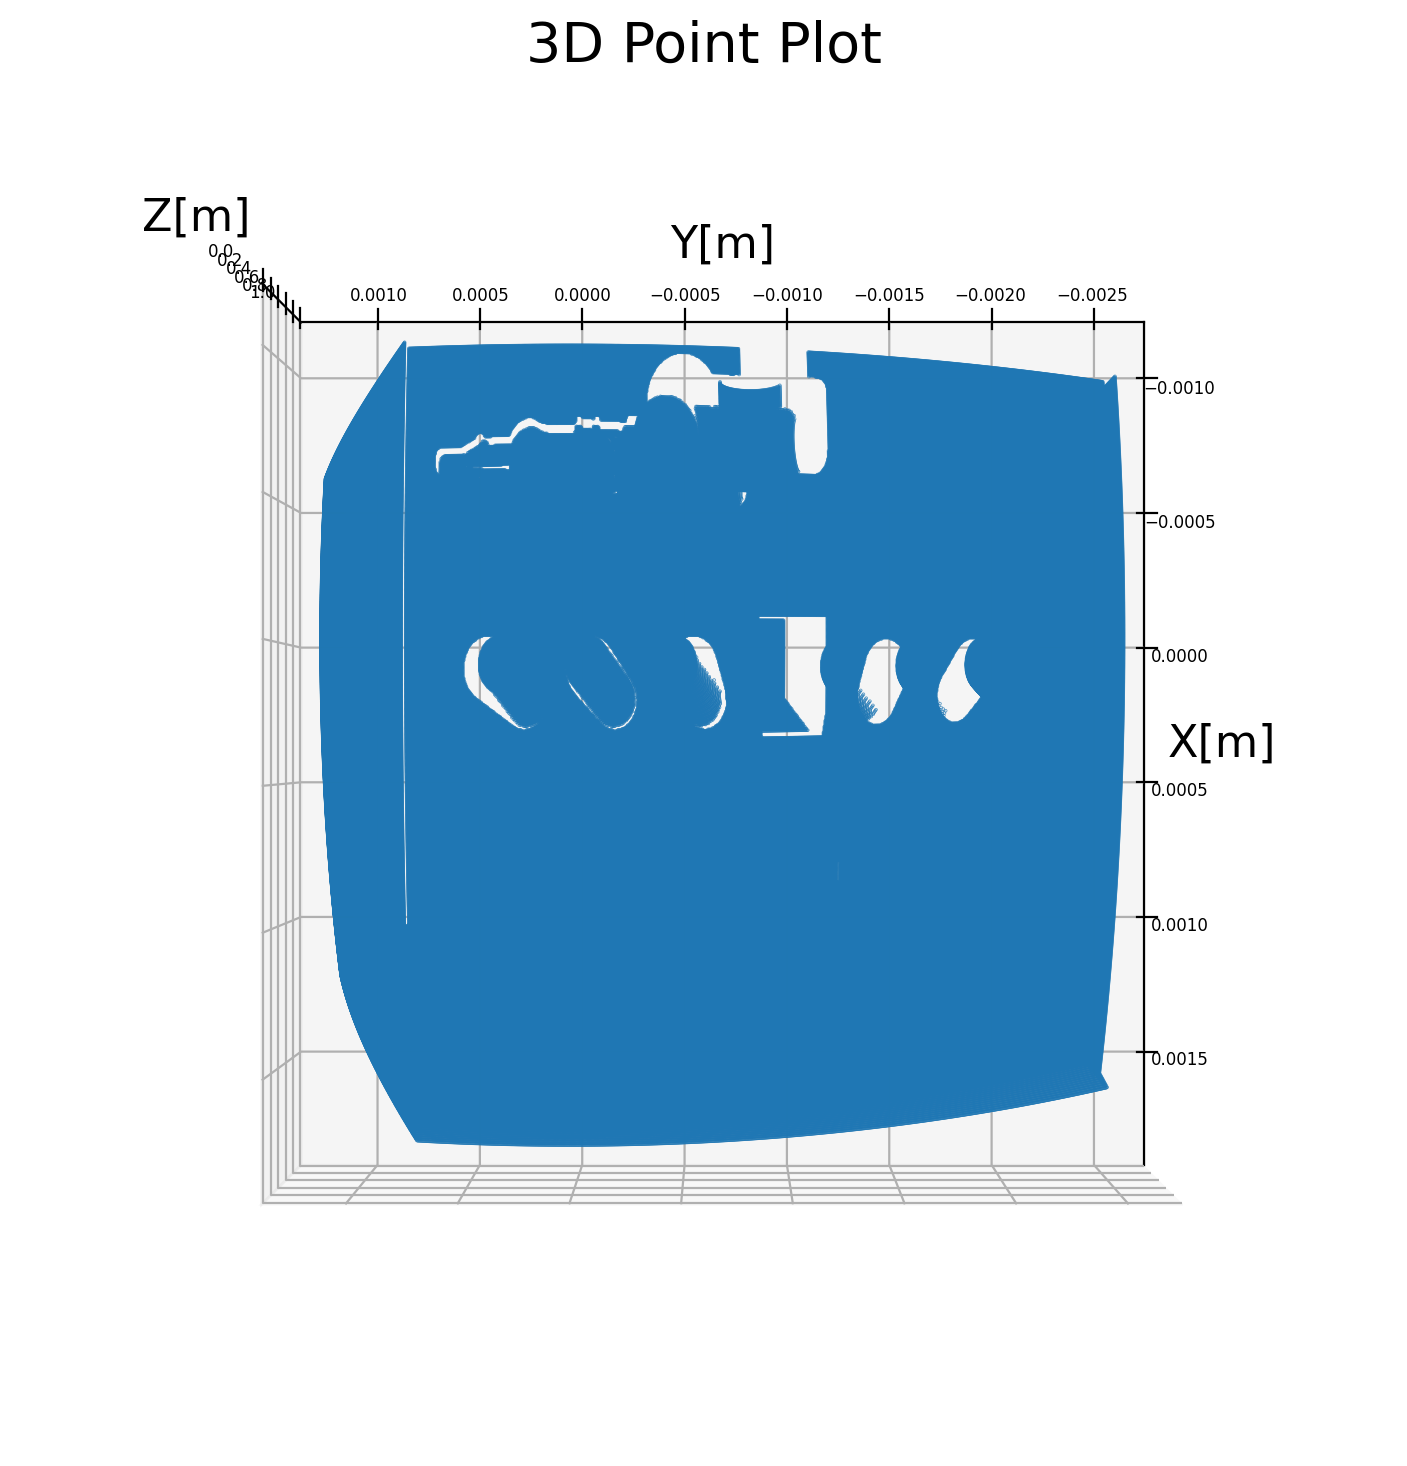

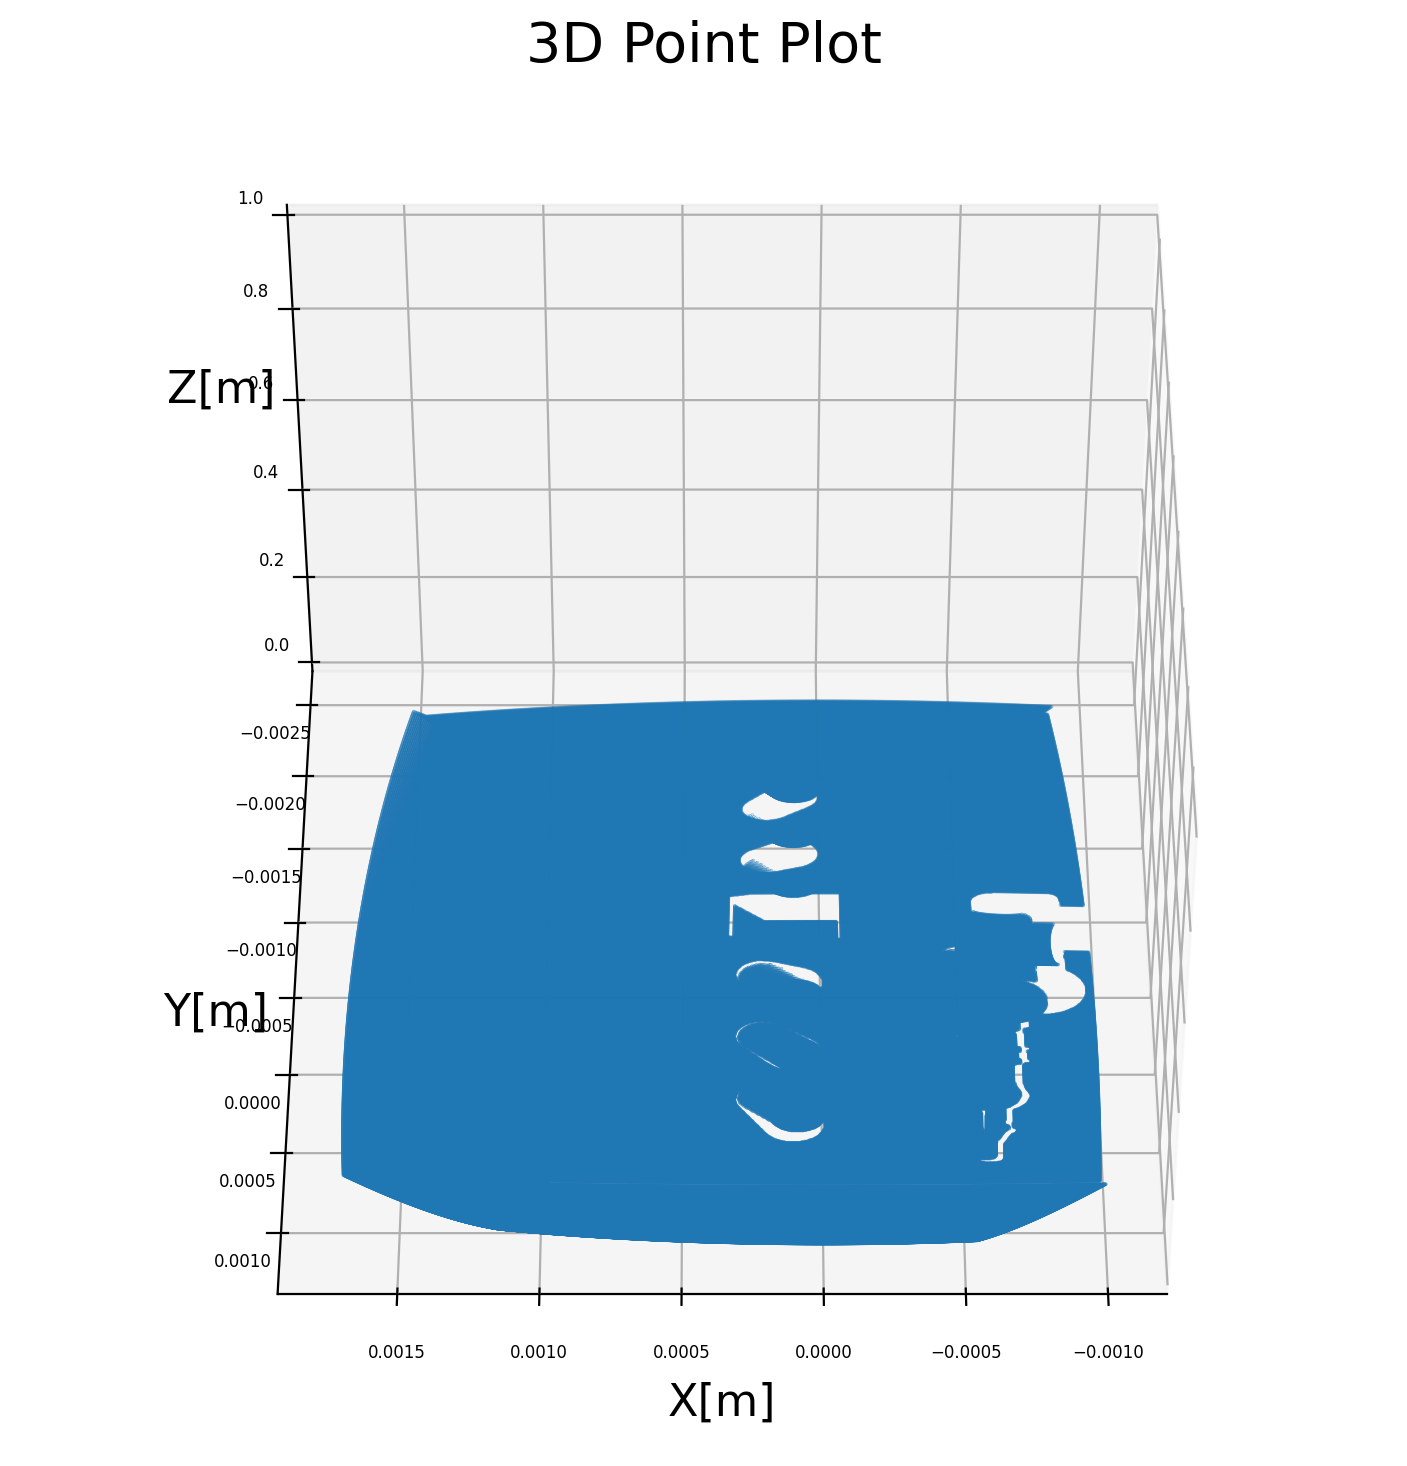

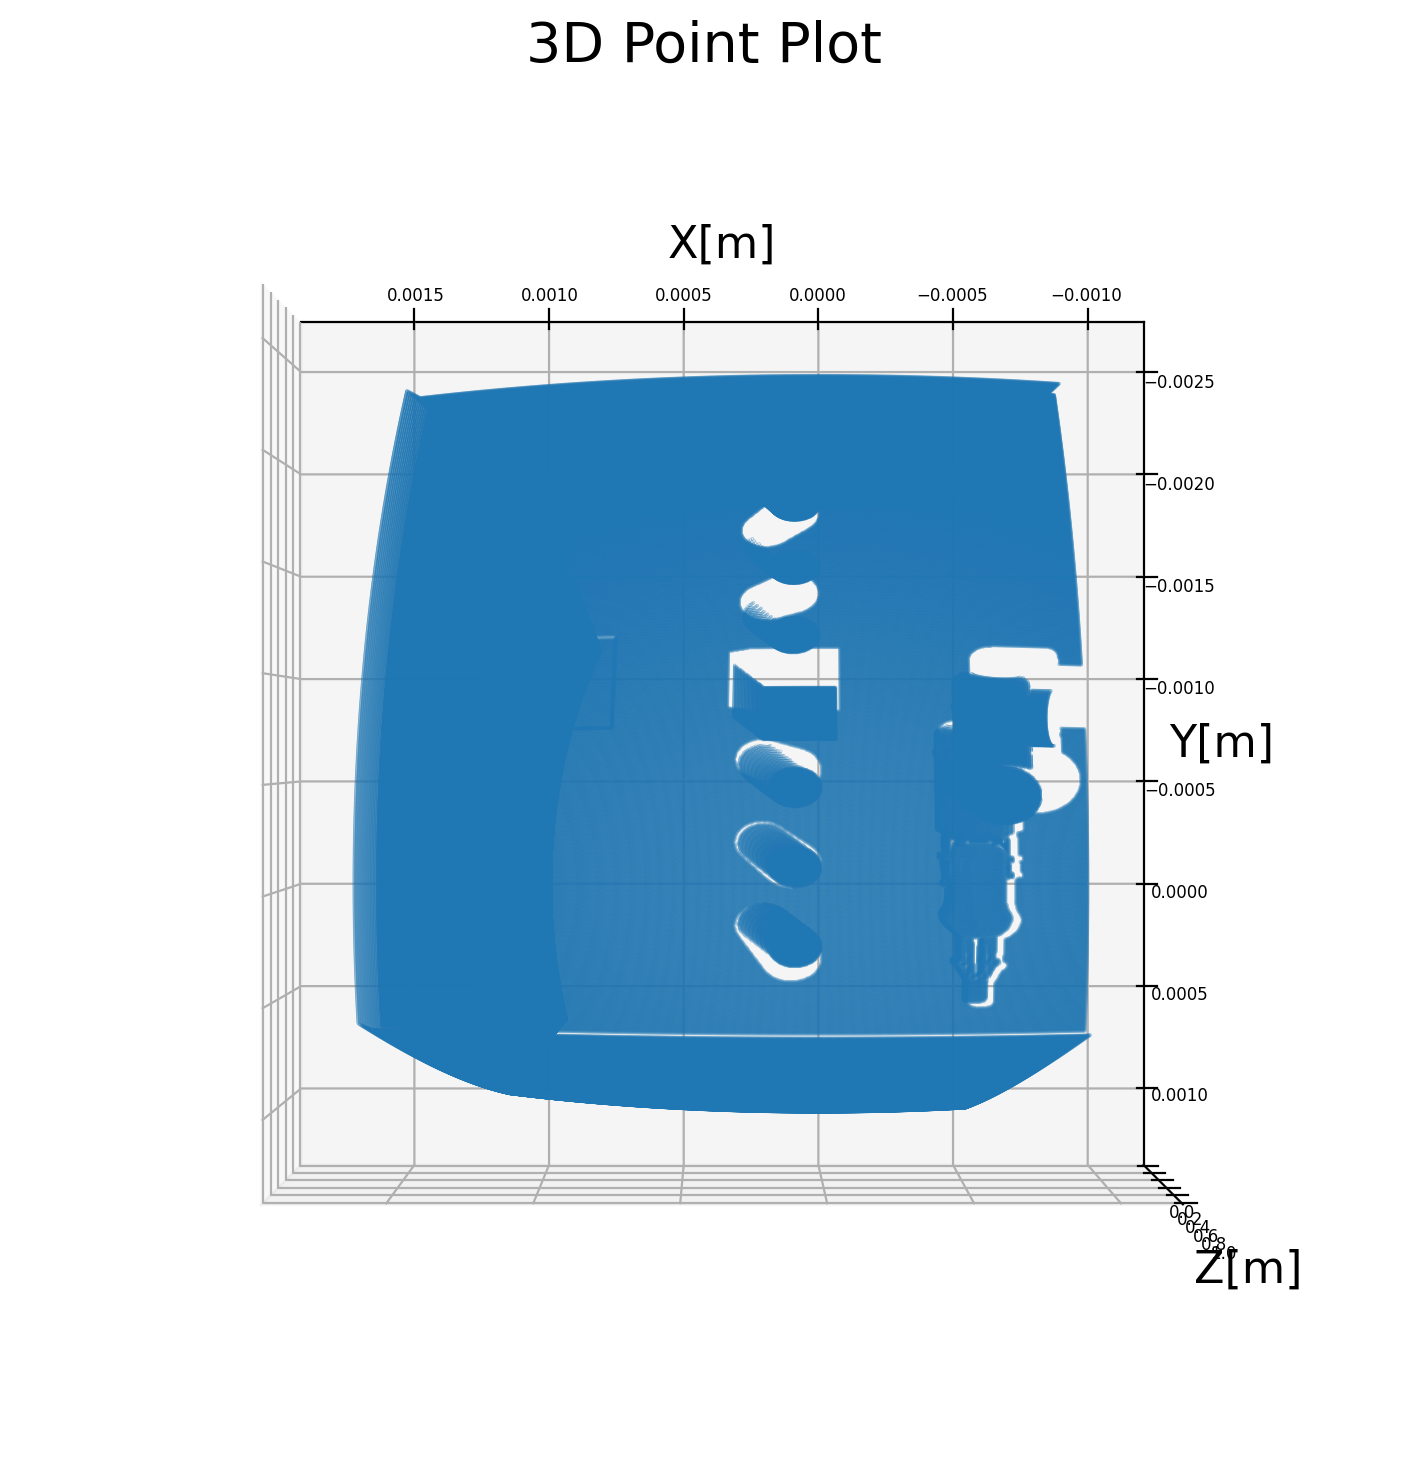

In [28]:
plot_point3d(img_3d_points, -45, 180, 0)
plot_point3d(img_3d_points, -90, 180, 0)

plot_point3d(img_3d_points, 45, 90, 0)
plot_point3d(img_3d_points, 90, 90, 0)

In [14]:
img_3d_points = convert_3d_position(img_real)

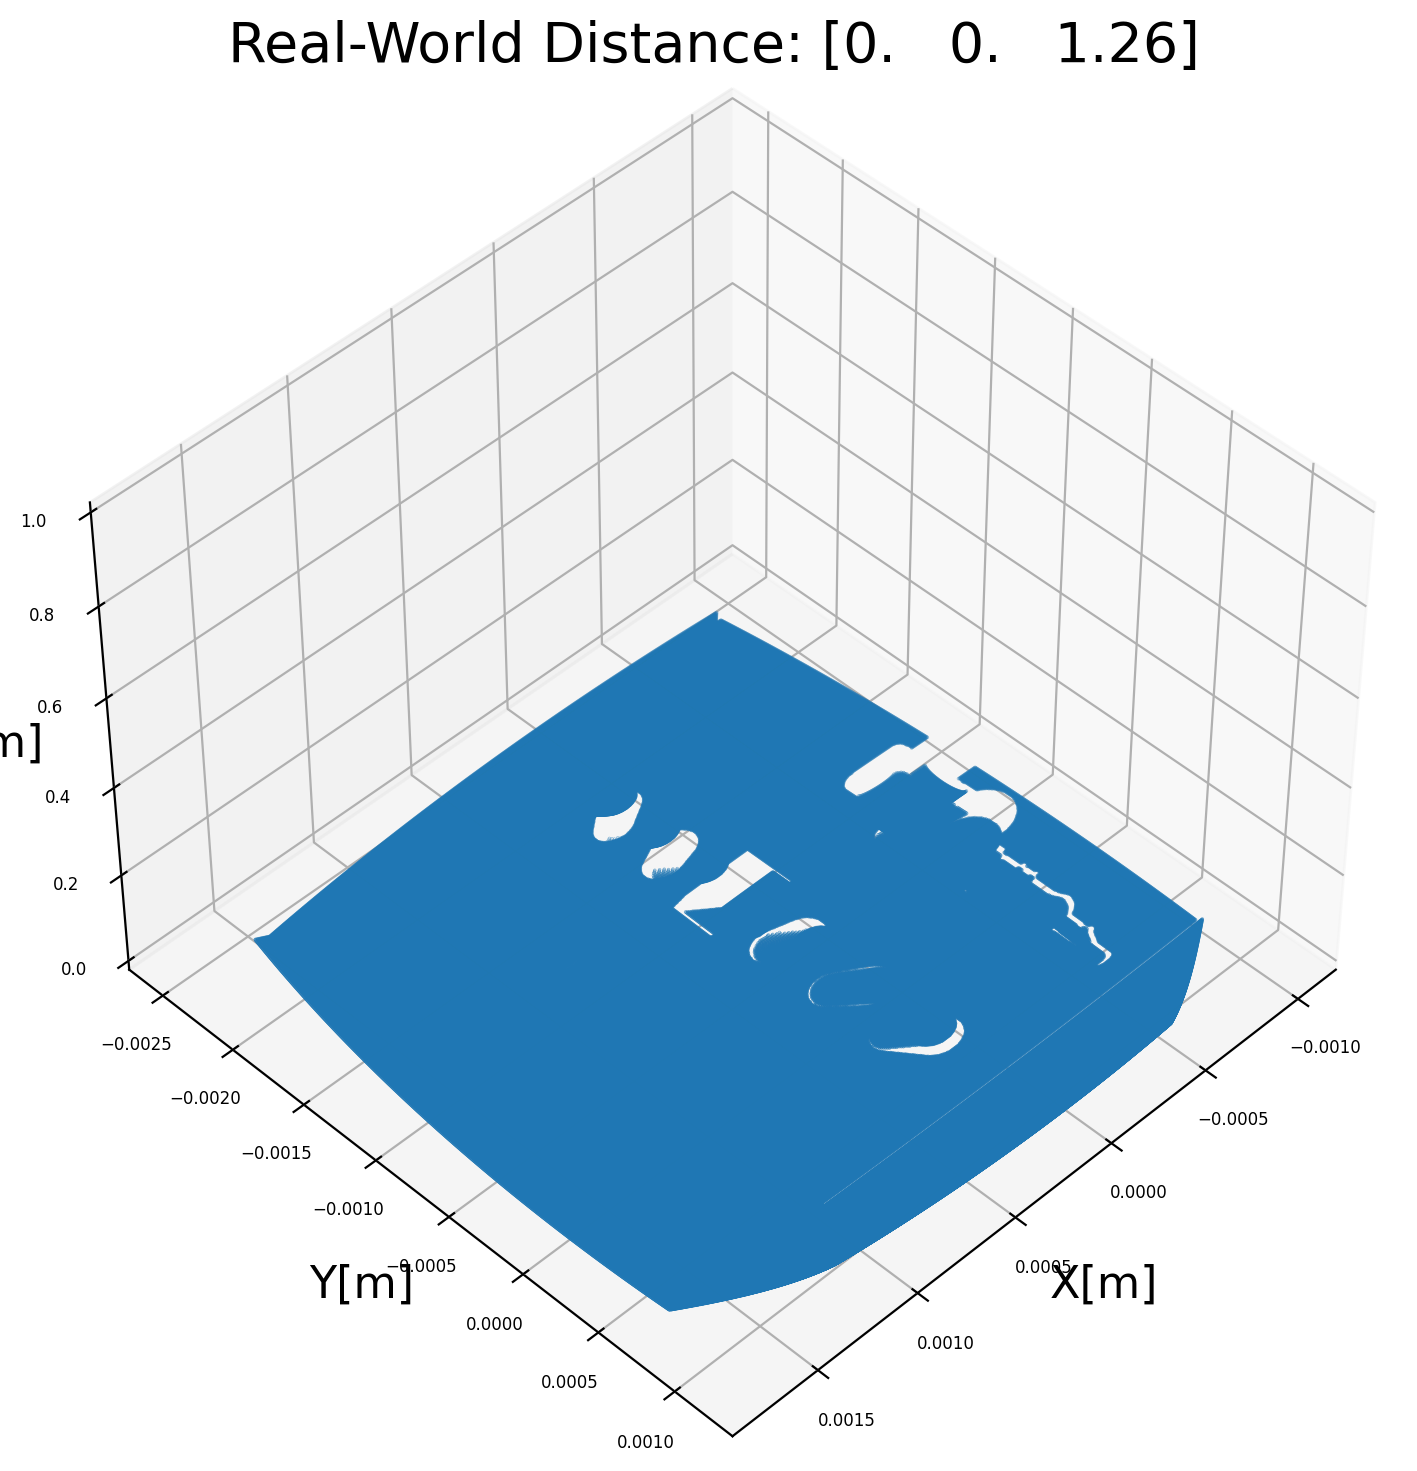

In [15]:
plot_3d_position(img_3d_points)

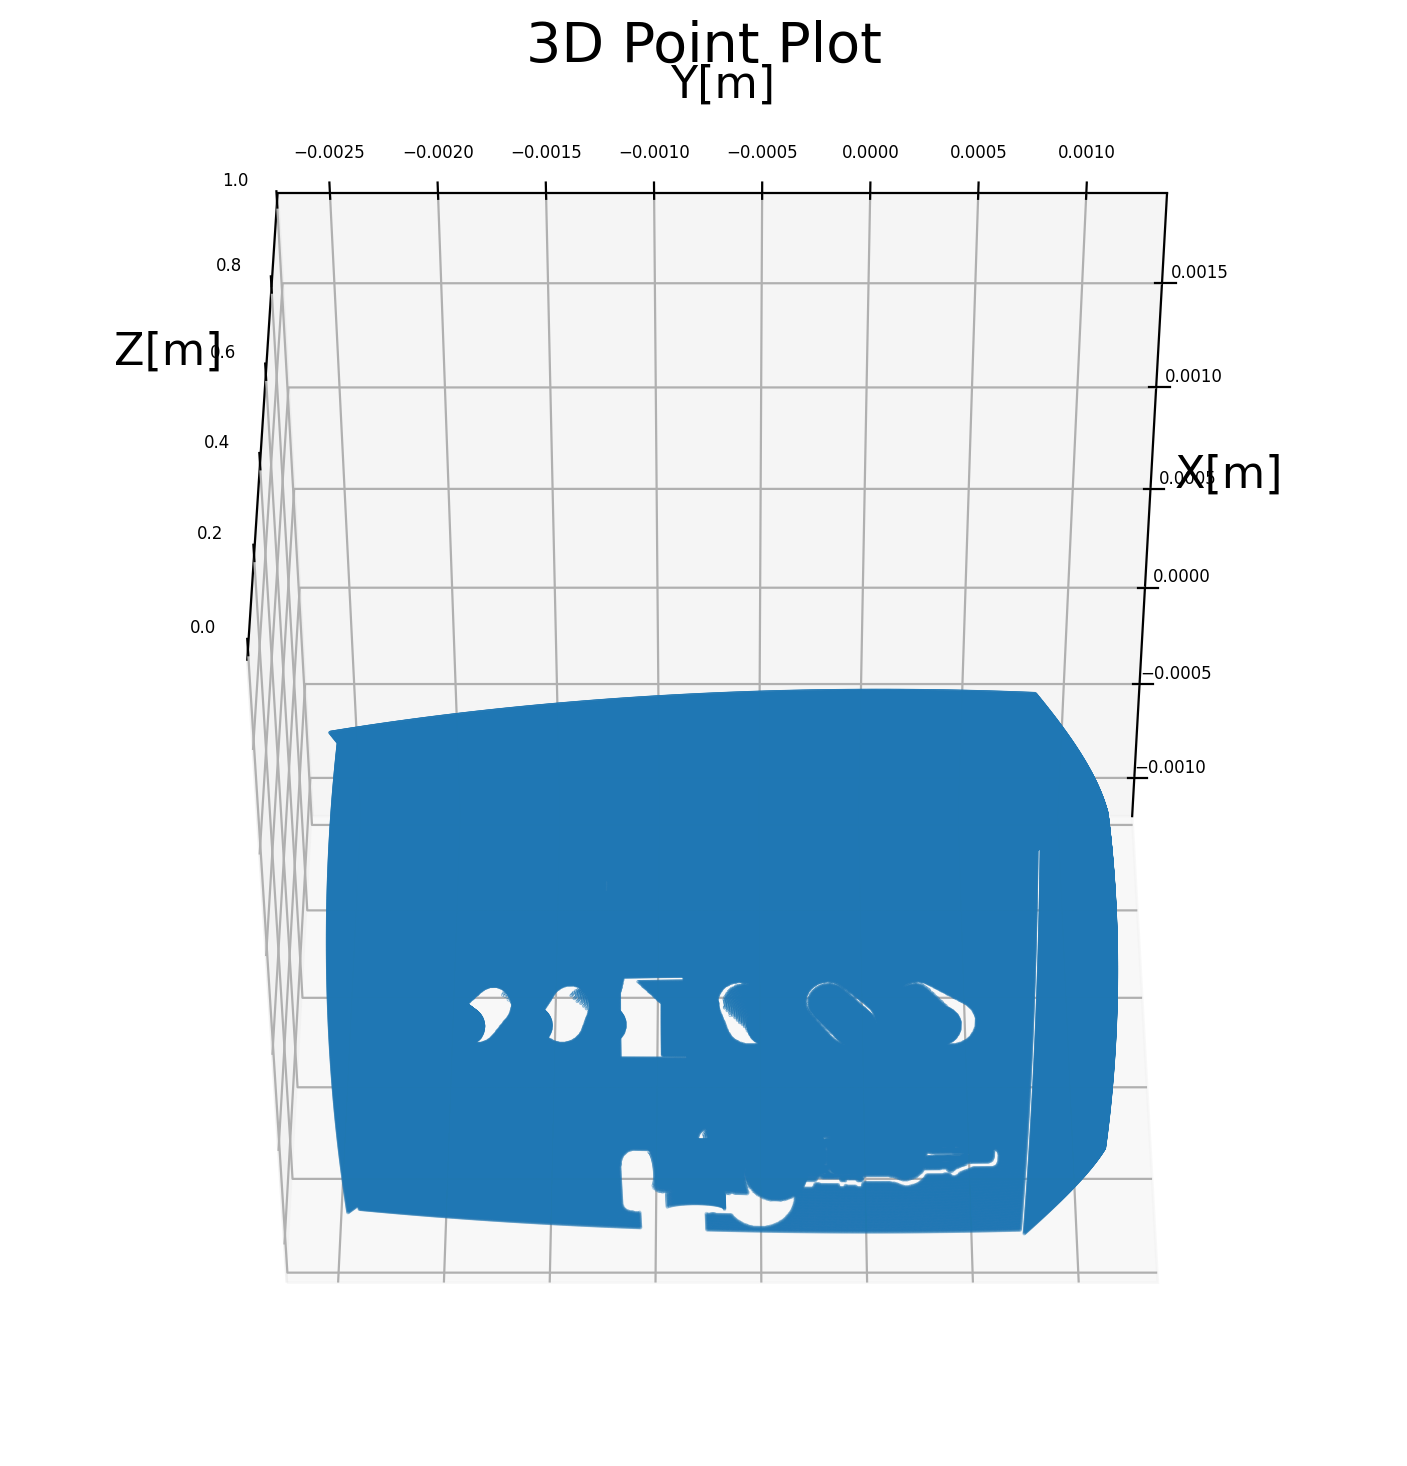

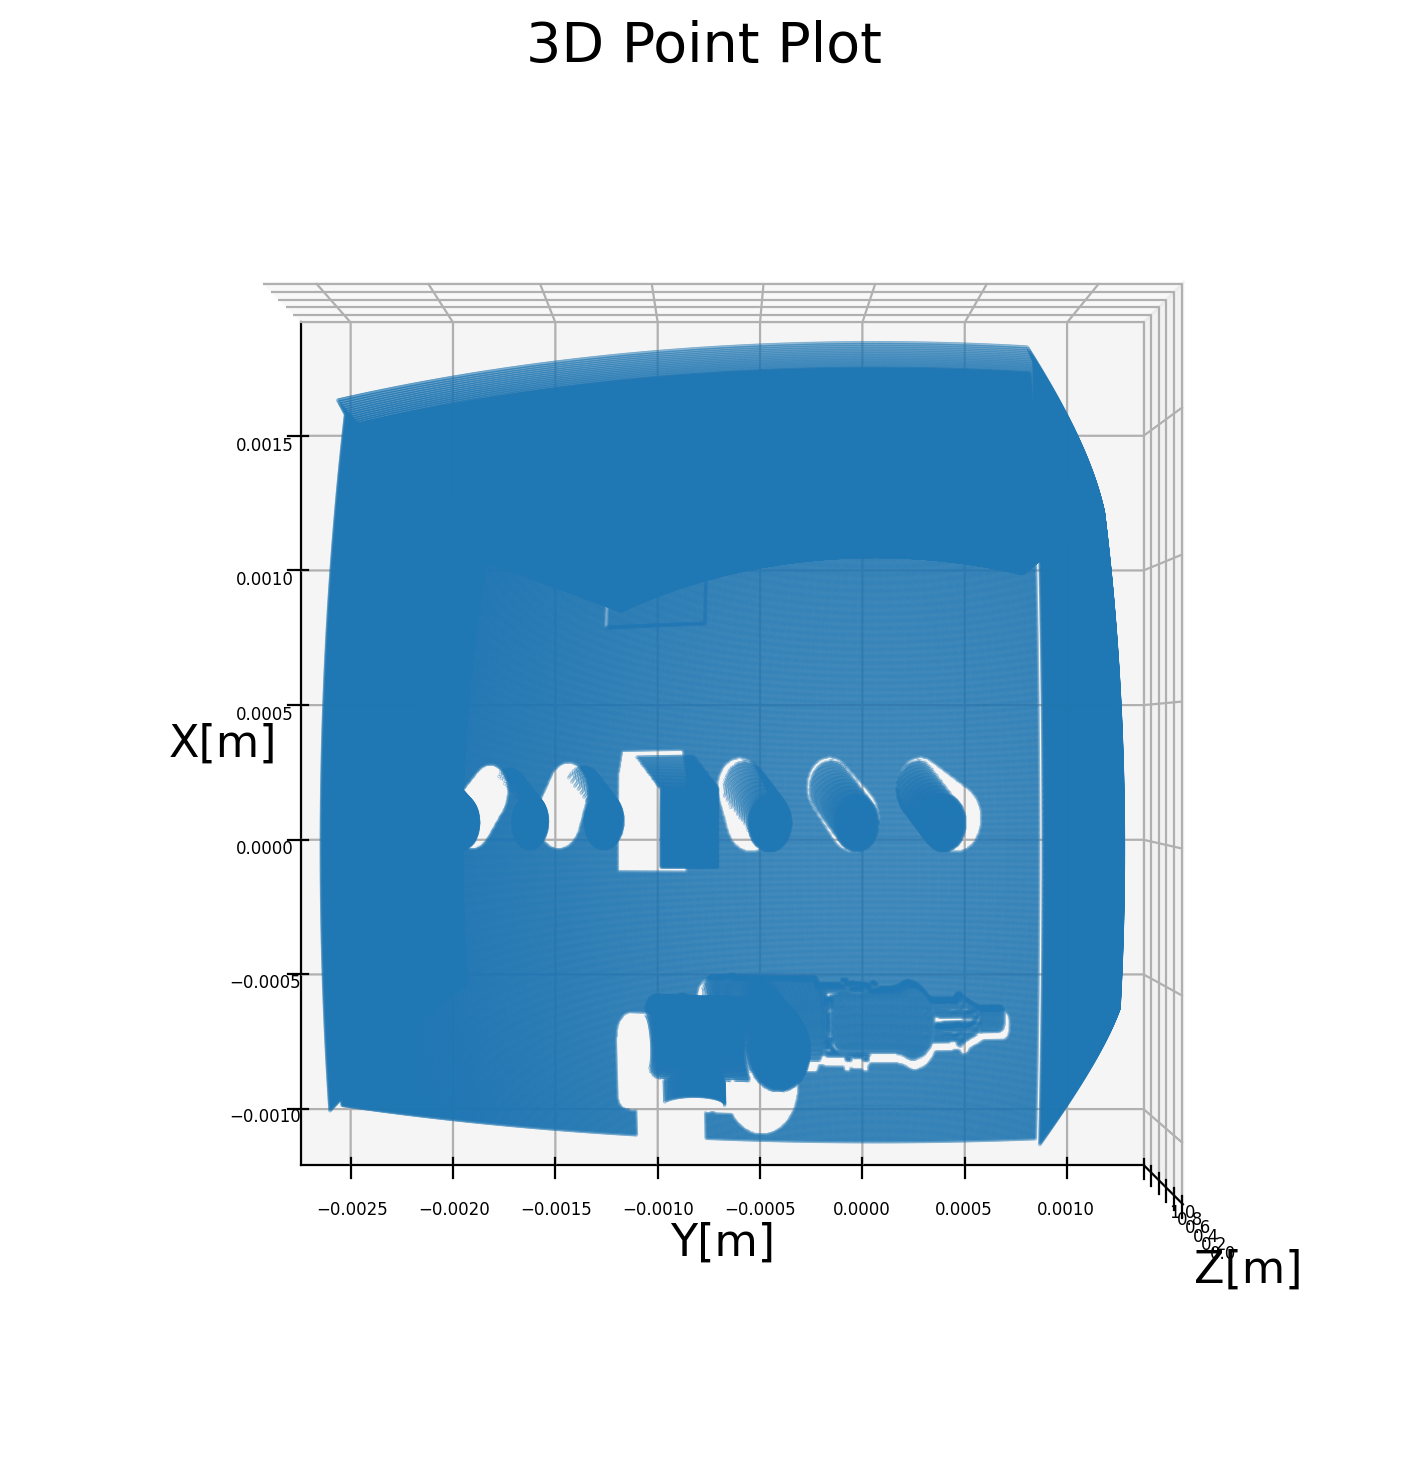

In [21]:
plot_point3d(img_3d_points, -45, 0, 0)
plot_point3d(img_3d_points, -90, 0, 0)

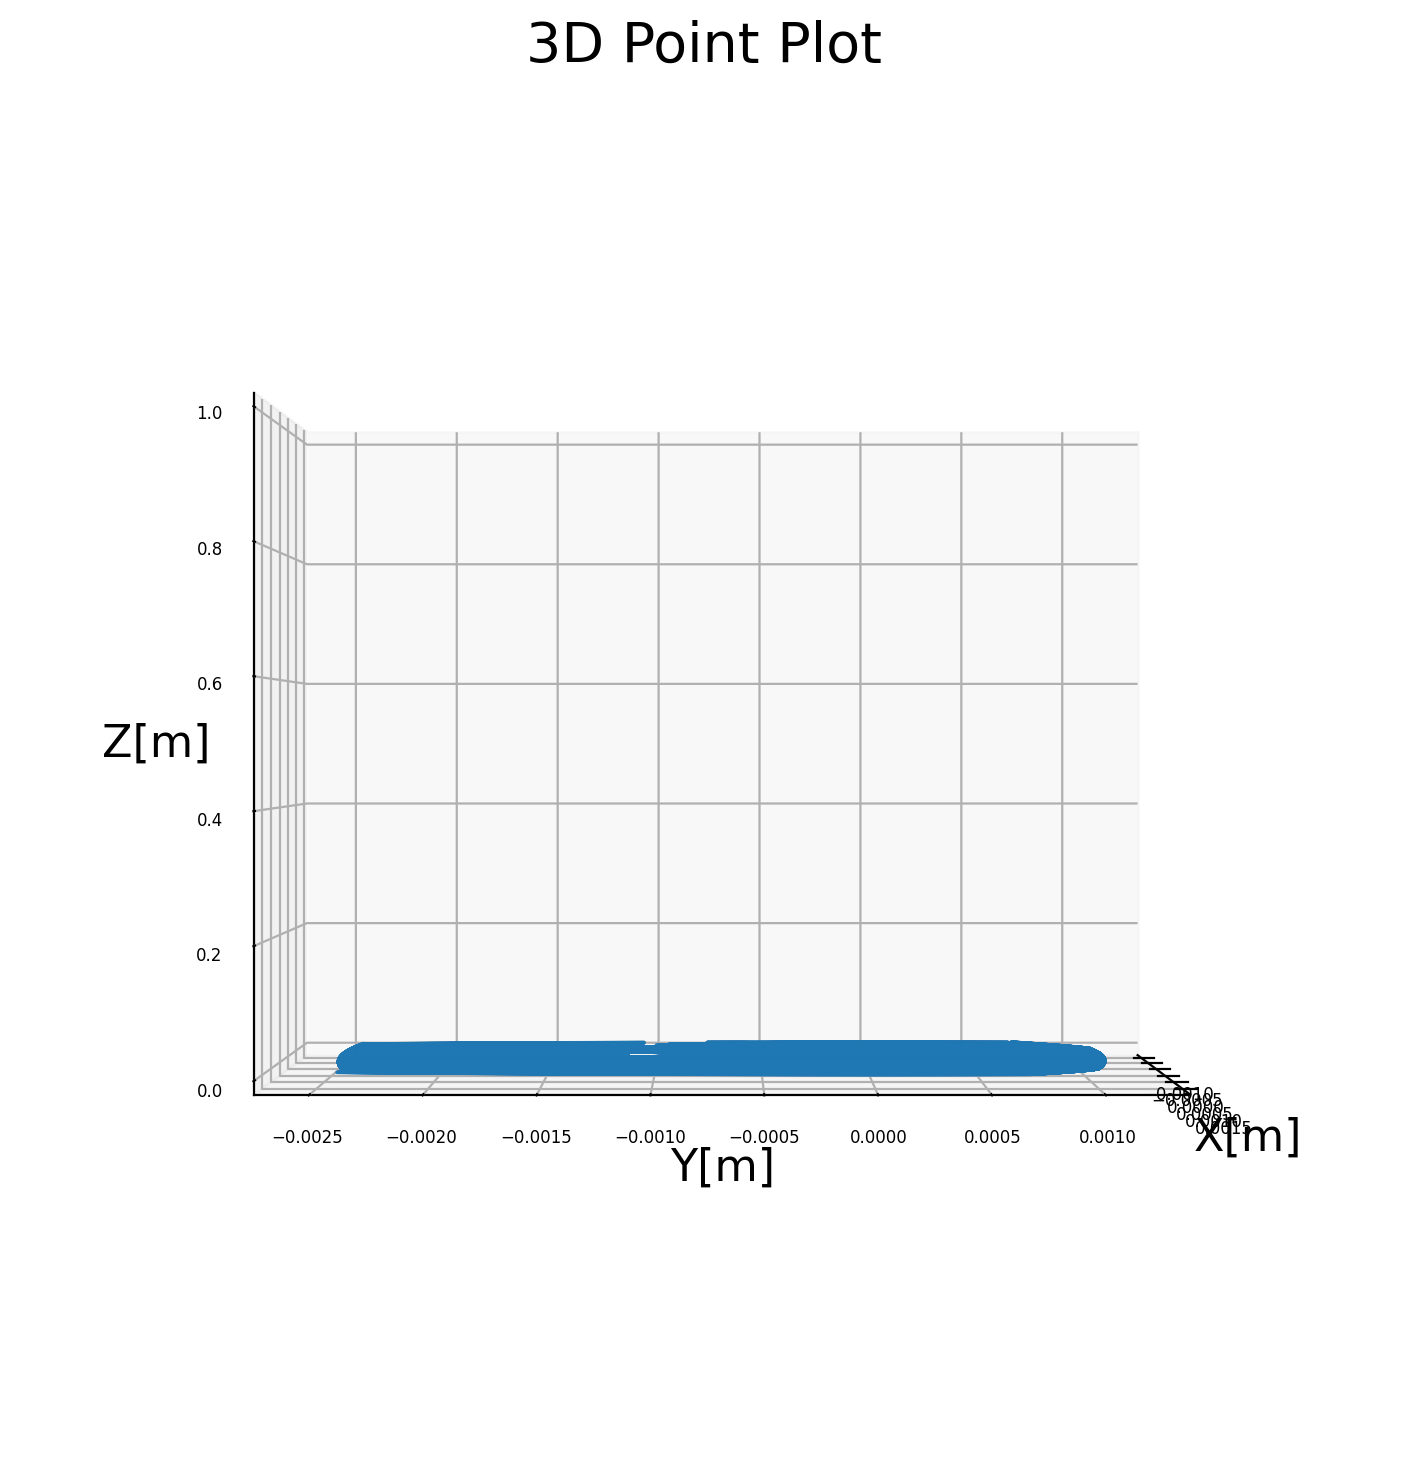

In [20]:
plot_point3d(img_3d_points, 0, 0, 0)

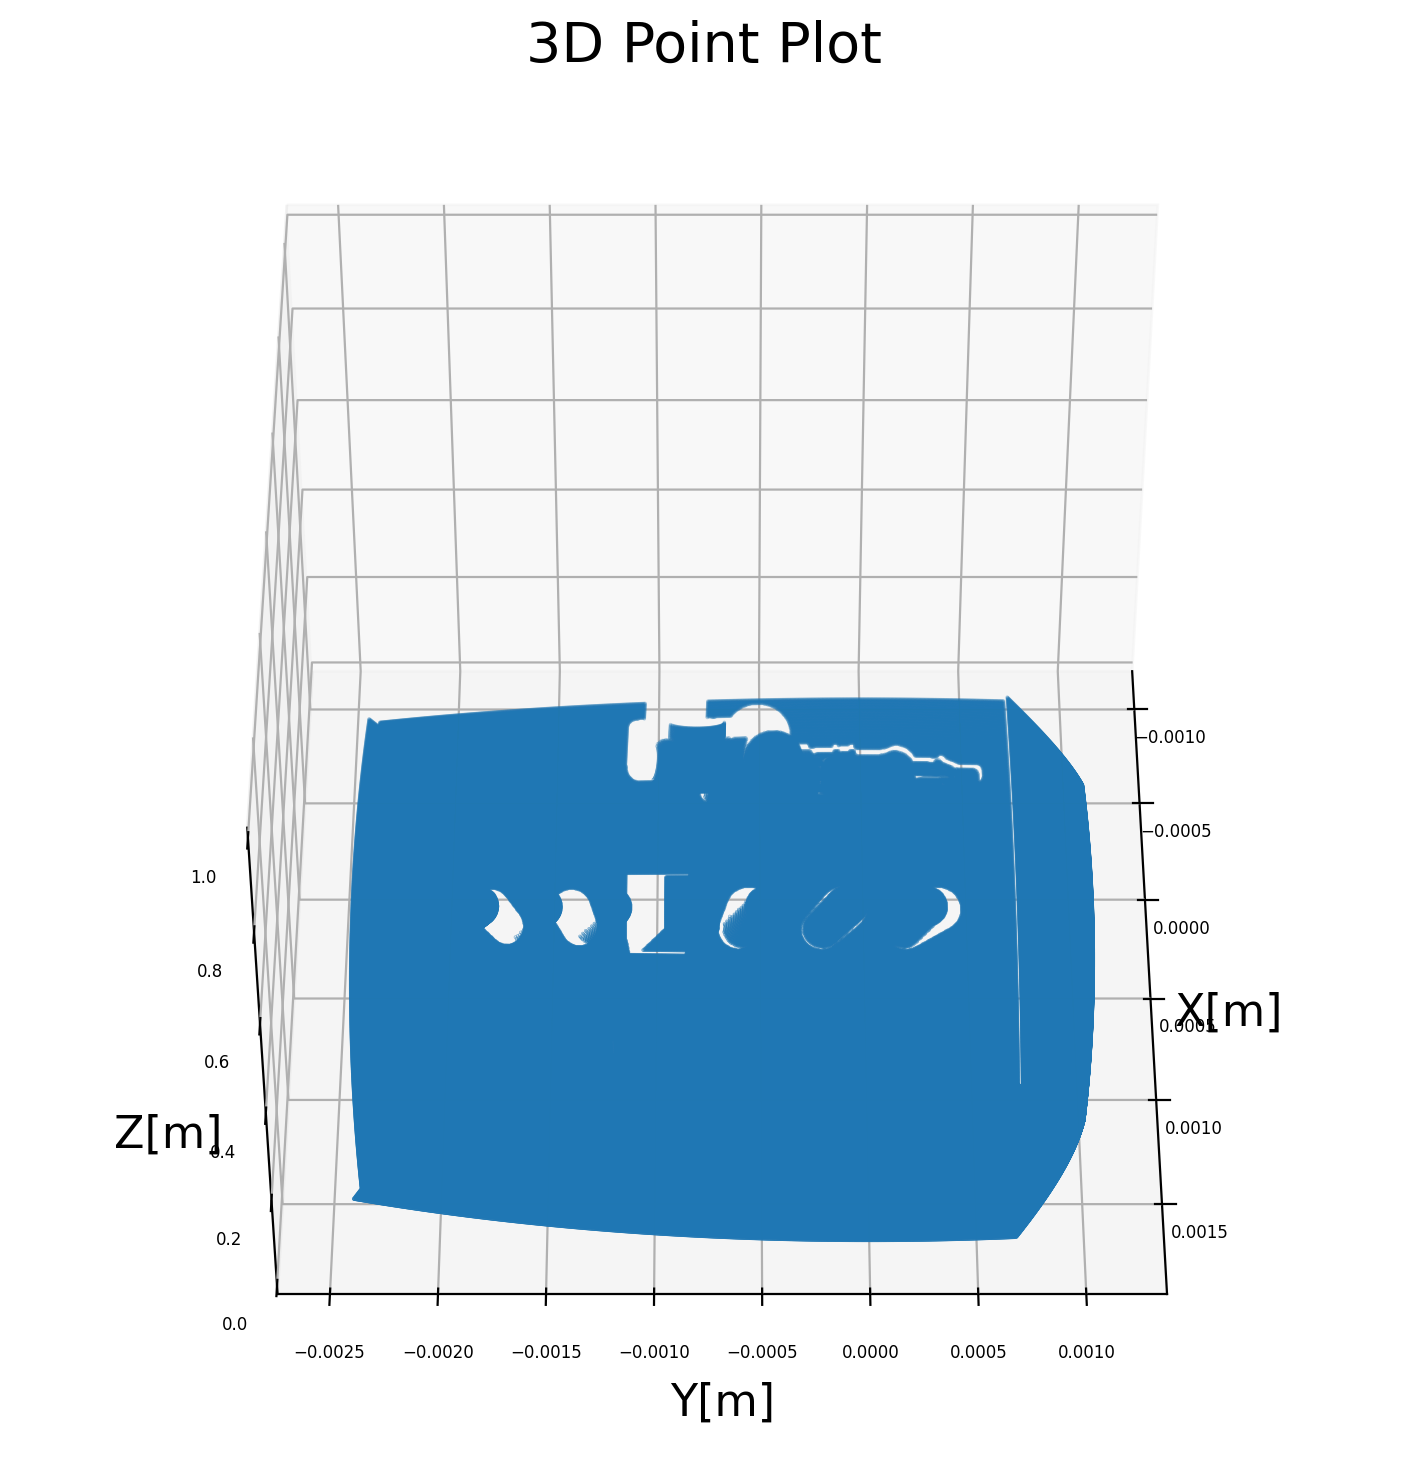

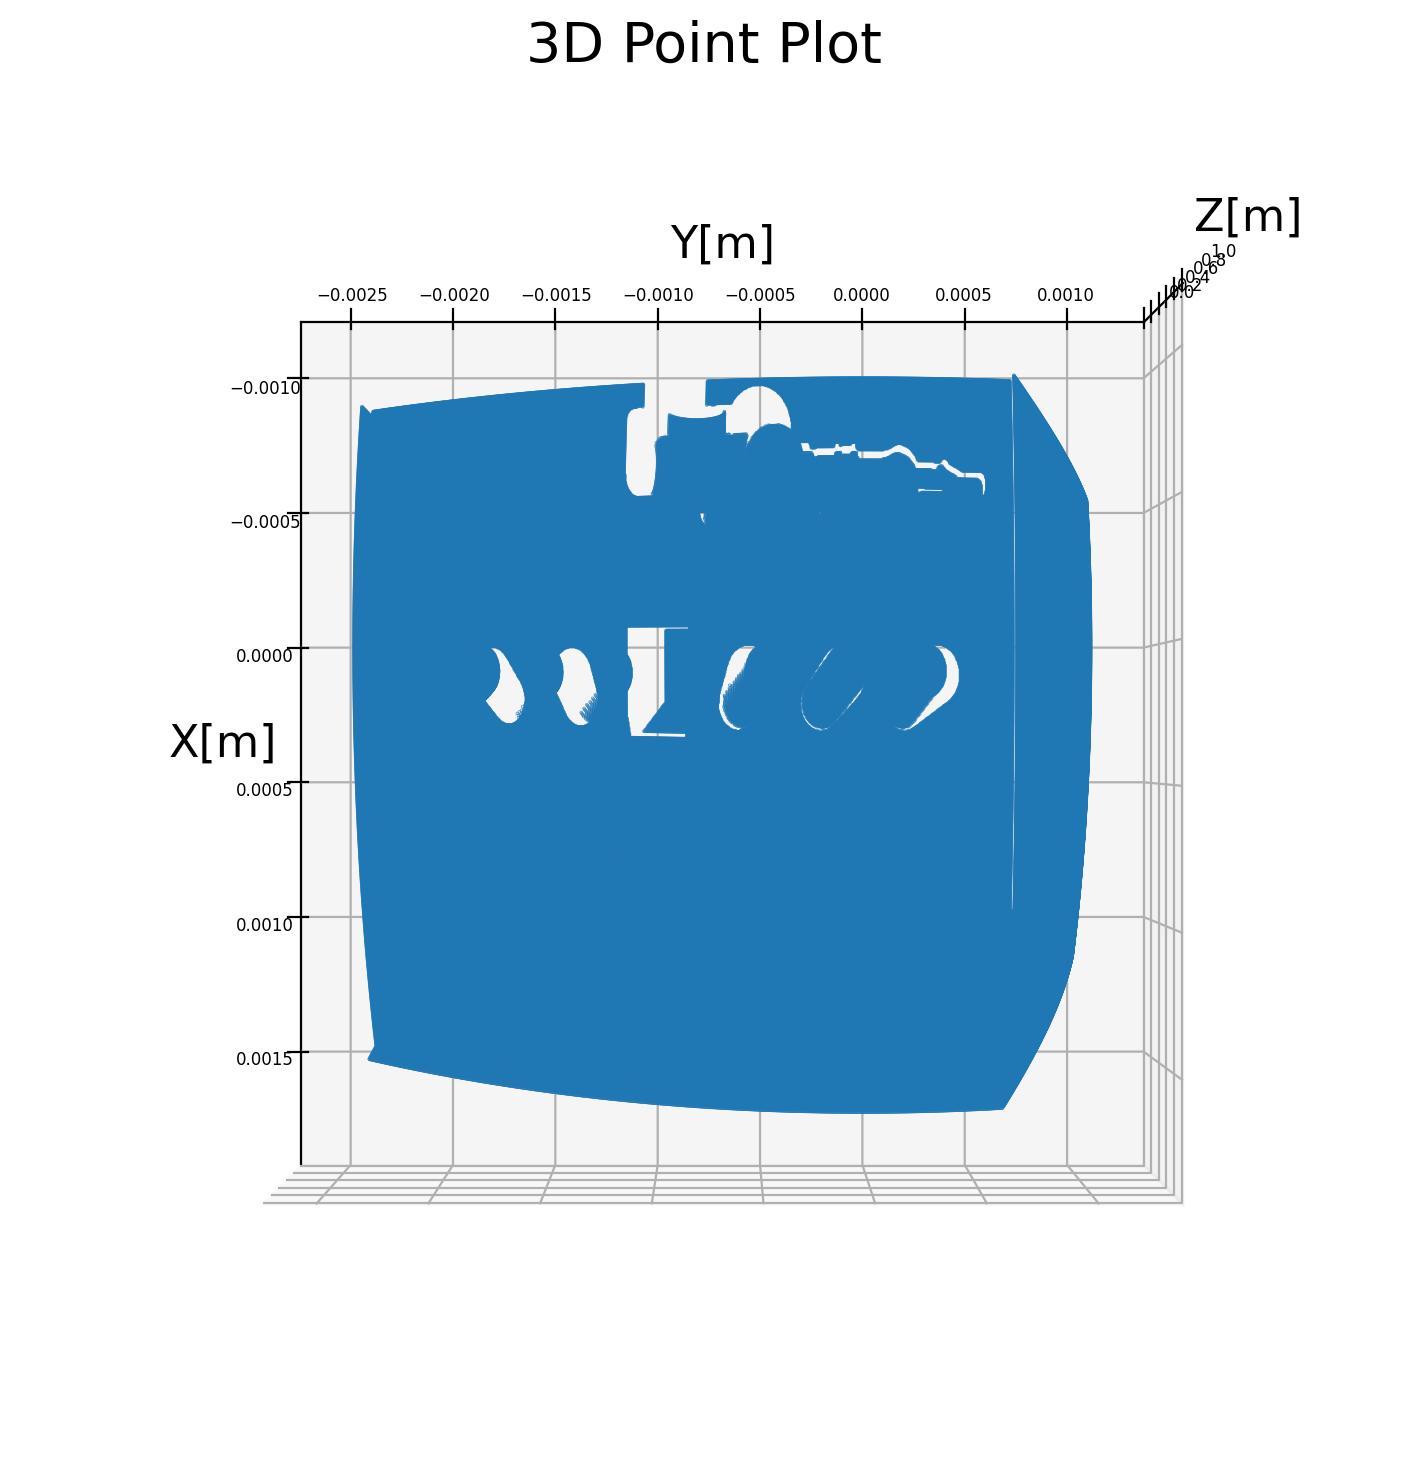

In [19]:
plot_point3d(img_3d_points, 45, 0, 0)
plot_point3d(img_3d_points, 90, 0, 0)

In [277]:
# 3D position of AprilTag Center-point
convert_from_uvd(center_int[0], center_int[1], img_real[center_int[0], center_int[1]])

(0.0010438242056250652, 0.0010438242056250652, 1.2600001986100162)

In [279]:
cam_id = env.model.camera_name2id("main1")
cam_rot_mat = env.model.cam_mat0[cam_id]
cam_rot_mat = cam_rot_mat.reshape(3, 3)

In [284]:
cam_rot_mat = np.array([[cam_rot_mat[0][0], cam_rot_mat[0][1],  cam_rot_mat[0][2], 0],
                [cam_rot_mat[1][0], cam_rot_mat[1][1],  cam_rot_mat[1][2], 0],
                [cam_rot_mat[2][0], cam_rot_mat[2][1],  cam_rot_mat[2][2], 0],
                [0, 			         0,  0, 0]])
cam_rot_mat

array([[ 0.69,  0.64,  0.33,  0.  ],
       [-0.33,  0.69, -0.64,  0.  ],
       [-0.64,  0.33,  0.69,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ]])

In [285]:
R_x = cam_rot_mat[:3, :3]@rpy2r(np.deg2rad([0,0,90]))@rpy2r(np.pi/2*np.array([1,0,0]))
R_y = cam_rot_mat[:3, :3]@rpy2r(np.deg2rad([0,0,90]))@rpy2r(np.pi/2*np.array([0,1,0]))
R_z = cam_rot_mat[:3, :3]@rpy2r(np.deg2rad([0,0,90]))@rpy2r(np.pi/2*np.array([0,0,1]))


In [286]:
R_x

array([[ 0.64,  0.33,  0.69],
       [ 0.69, -0.64, -0.33],
       [ 0.33,  0.69, -0.64]])

In [287]:
R_y

array([[-0.33, -0.69,  0.64],
       [ 0.64,  0.33,  0.69],
       [-0.69,  0.64,  0.33]])

In [288]:
R_z

array([[-0.69, -0.64,  0.33],
       [ 0.33, -0.69, -0.64],
       [ 0.64, -0.33,  0.69]])

In [363]:
R_all = R_z @ R_y @ R_x

R_all = np.array([[R_all[0][0], R_all[0][1],  R_all[0][2], 0],
                [R_all[1][0], R_all[1][1],  R_all[1][2], 0],
                [R_all[2][0], R_all[2][1],  R_all[2][2], 0],
                [0, 			         0,  0, 0]])
R_all

array([[-0.19, -0.98,  0.05,  0.  ],
       [-0.83,  0.19,  0.52,  0.  ],
       [-0.52,  0.05, -0.85,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ]])

In [373]:
cam_rot_mat

array([[ 0.69,  0.64,  0.33,  0.  ],
       [-0.33,  0.69, -0.64,  0.  ],
       [-0.64,  0.33,  0.69,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ]])

In [365]:
env.get_p_body(body_name='box_checker')

array([1.4 , 0.  , 0.74])

In [366]:
[1.4, 0., 2.0] - env.get_p_body(body_name='box_checker')

array([0.  , 0.  , 1.26])

In [375]:
rot_mat = Rotation_Y(np.deg2rad(90))
trans_mat = Translation(1.4,0,2.0)

ht_mat = HT_matrix(rot_mat, trans_mat)
# ht_mat = HT_matrix(cam_rot_mat, trans_mat)
# ht_mat = HT_matrix(R_all, trans_mat)

print(ht_mat)

point_3d = convert_from_uvd(center_int[0], center_int[1], img_real[center_int[0], center_int[1]])
print(f"3D point of AprilTag about Camera coordinate: \n -> {point_3d}")
# print(env.get_p_body(body_name='box_checker'))
# print([1.4, 0., 2.0])

calc_april = [1.4, 0., 2.0] - env.get_p_body(body_name='box_checker')
print(f"the calculated AprilTag position about Camera is : \n -> {calc_april}")

[[ 6.12e-17  0.00e+00  1.00e+00  1.40e+00]
 [ 0.00e+00  1.00e+00  0.00e+00  0.00e+00]
 [-1.00e+00  0.00e+00  6.12e-17  2.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]
3D point of AprilTag about Camera coordinate: 
 -> (0.0010438242056250652, 0.0010438242056250652, 1.2600001986100162)
the calculated AprilTag position about Camera is : 
 -> [0.   0.   1.26]


In [376]:
def c2b(transform_mat, points): # compute to base
    ones = np.ones((len(points),1))
    points = np.concatenate((points,ones),axis=1)
    t_points = points.T
    t_transformed_ponints = np.dot(transform_mat,t_points)
    transformed_ponints = t_transformed_ponints.T
    xyz = transformed_ponints[:,0:3]
    
    return xyz

In [378]:
xyz = c2b(ht_mat, [point_3d])
xyz

array([[2.66e+00, 1.04e-03, 2.00e+00]])

In [371]:
print(point_3d)
print(xyz)

(0.0010438242056250652, 0.0010438242056250652, 1.2600001986100162)
[[1.47 0.65 0.93]]


In [372]:
# world_xyz = c2b(ht_mat, [point_3d])
# world_xyz

### Object position: (1.4, 0.0, 0.74)
### Camera position: (1.4, 0.0, 2.0)
### Obj correspond to cam position: (0.0, 0.0, 1.26)

### DM-Control: intrinsic matrix

In [22]:
def matrix(env):
  """Returns the 3x4 camera matrix.
      For a description of the camera matrix see, e.g.,
      https://en.wikipedia.org/wiki/Camera_matrix.
      For a usage example, see the associated test.
  """
  # camera_id = -1
  camera_id = env.model.camera_name2id("main1")
  if camera_id == -1:
    # If the camera is a 'free' camera, we get its position and orientation
    # from the scene data structure. It is a stereo camera, so we average over
    # the left and right channels. Note: we call `self.update()` in order to
    # ensure that the contents of `scene.camera` are correct.
    pos = np.mean(env.scene.camera.pos, axis=0)
    z = -np.mean(env.scene.camera.forward, axis=0)
    y = np.mean(env.scene.camera.up, axis=0)
    rot = np.vstack((np.cross(y, z), y, z))
    fov = env._physics.model.vis.global_.fovy
  else:
    pos = env.model.cam_pos0[camera_id]
    rot = env.model.cam_mat0[camera_id].reshape(3,3).T
    # pos = env._physics.data.cam_xpos[camera_id]
    # rot = env._physics.data.cam_xmat[camera_id].reshape(3, 3).T
    # fov = env._physics.model.cam_fovy[camera_id]
    fov = env.model.cam_fovy[camera_id]

  # Translation matrix (4x4).
  translation = np.eye(4)
  translation[0:3, 3] = -pos
  # Rotation matrix (4x4).
  rotation = np.eye(4)
  rotation[0:3, 0:3] = rot
  # Focal transformation matrix (3x4).
  focal_scaling = (1./np.tan(np.deg2rad(fov)/2)) * env.render_height / 2.0
  focal = np.diag([-focal_scaling, focal_scaling, 1.0, 0])[0:3, :]
  # Image matrix (3x3).
  image = np.eye(3)
  image[0, 2] = (env.render_width - 1) / 2.0
  image[1, 2] = (env.render_height - 1) / 2.0
  return image @ focal @ rotation @ translation

In [23]:
camera_id = env.model.camera_name2id("main1")

rot = env.model.cam_mat0[camera_id].reshape(3, 3).T
rot

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [24]:
AA = matrix(env)

In [25]:
AA

array([[-1.21e+03,  0.00e+00,  7.50e+02, -2.15e+03],
       [ 0.00e+00,  1.21e+03,  5.00e+02, -2.00e+03],
       [ 0.00e+00,  0.00e+00,  1.00e+00, -4.00e+00]])

In [15]:
# Focal transformation matrix (3x4).
focal_scaling = (1./np.tan(np.deg2rad(45)/2)) * env.render_height / 2.0
focal = np.diag([-focal_scaling, focal_scaling, 1.0, 0])[0:3, :]
focal

array([[-1.21e+03,  0.00e+00,  0.00e+00,  0.00e+00],
       [ 0.00e+00,  1.21e+03,  0.00e+00,  0.00e+00],
       [ 0.00e+00,  0.00e+00,  1.00e+00,  0.00e+00]])